# Modelo de Identificação de Parcialidade em Notícias Jornalísticas


In [13]:
# coding: utf-8

"""
Mapeamento dos Arquivos
"""

BASE = '/content/drive/MyDrive/Colab Notebooks/base_analytics.csv'
BASE_FINAL = '/content/drive/MyDrive/Colab Notebooks/base_analytics_final.csv'

MODEL_GENERATOR = True
EPOCHS = 10
BATCH_SIZE = 1000

MODEL_SENTI = '/content/drive/MyDrive/Colab Notebooks/model_bidirecional_senti.h5'
HISTORY_RESULTS_SENTI = '/content/drive/MyDrive/Colab Notebooks/history_results_bidirecional_senti.csv'

MODEL_NAIVE = '/content/drive/MyDrive/Colab Notebooks/model_bidirecional_naive.h5'
HISTORY_RESULTS_NAIVE = '/content/drive/MyDrive/Colab Notebooks/history_results_bidirecional_naive.csv'

WORD2VEC_S50 = '/content/drive/MyDrive/Colab Notebooks/word2vec_s50.txt'


In [14]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Carregamento do WordEmbedding


In [15]:
from gensim.models import KeyedVectors

# Carregar o Word Embedding Pré-Treinado
Word2Vec = KeyedVectors.load_word2vec_format(WORD2VEC_S50)

MAX_NB_WORDS = len(Word2Vec.vocab)
EMBEDDING_DIM = 50

print("\nTamanhos dos vocabulários:\n -> Word2Vec - " + str(MAX_NB_WORDS))



Tamanhos dos vocabulários:
 -> Word2Vec - 929606


### Preparação das Bases


*   Base de Treinamento Senti Strength
*   Base de Treinamento Naive Bayes
*   Base de Teste



In [16]:
import re
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

stopWords = set(stopwords.words('portuguese'))

"""
É descartado a palavra Não das StopWords pelo seu impacto no sentido da frase.
"""
stopWords.discard('não')

base = pd.read_csv(BASE, sep=';', index_col=None,
    names=[
        'article',
        'title',
        'type',
        'typeNaive',
        'typeSenti',
        'positivo',
        'negativo',
        'neutro',
        'link',
        'origem',
        'id',
        'length',
        'count_neutral_words',
        'lenght_caract'
    ]
)


def clean_text(text):
    """
    Realiza a preparação do texto para ser utilizada
    Removendo pontuações, links, aspas e tornando tadas as letras em minúsculo
    Removendo as StopWords
    """

    text = re.sub(r'[^\w\s$]|http\S+', '', text).lower()
    text = text.replace(r'/[\'"]+/g', '')
    text = ' '.join(word for word in text.split() if word not in stopWords)
    
    return text

base['article_clean'] = base['article'].apply(clean_text)

base['article_len'] = base['article_clean'].apply(lambda x : len(x))

MAX_LEN = int(base['article_len'].quantile(.75))
#75% do dataset pelo menos tem no maximo esse valor de tamanho
print("\nTamanhos Máximo das Notícias da Base:\n -> 75% do dataset - " + str(MAX_LEN))

base['article_tokens'] = base['article_clean'].apply(lambda text : word_tokenize(text.strip()) )

def create_x(tokens, embedding_model):
    """
    Buscar a localização dos tokens dentro do Word2Vec
    """

    list_x = []
    for token in tokens:
        if(token):
            if(token in embedding_model.vocab):
                list_x.append(embedding_model.vocab[token].index)
        
    return list_x

base['article_tokens_word2vec'] = base['article_tokens'].apply(lambda text : create_x(text, Word2Vec))

base.head(2)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

Tamanhos Máximo das Notícias da Base:
 -> 75% do dataset - 2396


,article,title,type,typeNaive,typeSenti,positivo,negativo,neutro,link,origem,id,length,count_neutral_words,lenght_caract,article_clean,article_len,article_tokens,article_tokens_word2vec
0,"Doria chama gestão da pandemia de 'descaso', e...","Doria chama gestão da pandemia de 'descaso', e...",NaN,partial,partial,2,-3,-1,https://diariodonordeste.verdesmares.com.br/po...,Diário do Nordeste,1,25,4,2449,doria chama gestão pandemia descaso queiroga d...,1907,"[doria, chama, gestão, pandemia, descaso, quei...","[18328, 2200, 658, 33346, 28604, 54972, 222, 1..."
1,Câmara aprova suspensão da carteira do motoris...,Câmara aprova suspensão da carteira do motoris...,NaN,partial,partial,3,-3,-1,https://g1.globo.com/politica/noticia/2021/09/...,G1 Ceará,2,24,4,3435,câmara aprova suspensão carteira motorista pub...,2564,"[câmara, aprova, suspensão, carteira, motorist...","[444, 7227, 2480, 3965, 2671, 5488, 14052, 162..."


In [17]:
training = base[~base['type'].isin(['impartial', 'partial'])]
test = base[base['type'].isin(['impartial', 'partial'])]

lenBase = len(base)
lenTraining = len(training)
lenTest = len(test)

labels = base['type'].value_counts().axes[0].tolist()

counts_labels_human_type = test['type'].value_counts()
counts_labels_naive_type = training['typeNaive'].value_counts()
counts_labels_senti_type = training['typeSenti'].value_counts()

dataFrameAnalyticsBase = pd.DataFrame(columns=['base', 'length', labels[0], labels[1]])

dataFrameAnalyticsBase = dataFrameAnalyticsBase.append({
    'base': "Base Total",
    'length': lenBase,
    labels[0]: '-',
    labels[1]: '-'
}, ignore_index=True)

dataFrameAnalyticsBase = dataFrameAnalyticsBase.append({
    'base': "Base Training Naive Bayes",
    'length': lenTraining,
    labels[0]: counts_labels_naive_type[labels[0]],
    labels[1]: counts_labels_naive_type[labels[1]]
}, ignore_index=True)

dataFrameAnalyticsBase = dataFrameAnalyticsBase.append({
    'base': "Base Training Senti Strength",
    'length': lenTraining,
    labels[0]: counts_labels_senti_type[labels[0]],
    labels[1]: counts_labels_senti_type[labels[1]]
}, ignore_index=True)

dataFrameAnalyticsBase = dataFrameAnalyticsBase.append({
    'base': "Base Test",
    'length': lenTest,
    labels[0]: counts_labels_human_type[labels[0]],
    labels[1]: counts_labels_human_type[labels[1]]
}, ignore_index=True)

dataFrameAnalyticsBase


,base,length,impartial,partial
0,Base Total,18175,-,-
1,Base Training Naive Bayes,17875,10102,7773
2,Base Training Senti Strength,17875,8339,9536
3,Base Test,300,232,68


### Preparação do MODELO

In [18]:
import numpy as np

def create_embedding_matrix(vocab, n_words, emb_size):
    """
    Transformar o Word2Vec em uma matrix
    """

    pret_embedding = {}

    """
    Retorna uma nova matriz de forma e tipo fornecidos, preenchida com zeros.
    n_words - Tamanho da matriz
    emb_size - Comprimento de zeros
    """
    embedding_matrix = np.zeros((n_words, emb_size))
    count = 0

    """
    Dicionário com todos os ids e palavras do embedding pré-treinado
    Chave como a palavra buscada e Value como a chave de localização no Word2Vec
    """
    for index, word in enumerate(vocab.index2word):
        pret_embedding[word] = index

    # Construindo a embedding_matrix do embedding pré-treinado
    for item in pret_embedding.items():
        if item[1] < n_words:
            count += 1
            embedding_vector = vocab.word_vec(item[0])
            
            if embedding_vector is not None:
                embedding_matrix[item[1]] = embedding_vector
    
    return embedding_matrix

if (MODEL_GENERATOR):
    embedding_matrix = create_embedding_matrix(Word2Vec, MAX_NB_WORDS, EMBEDDING_DIM)
    print(embedding_matrix.shape)


(929606, 50)


In [19]:
import pandas as pd
from keras.preprocessing.sequence import pad_sequences

if (MODEL_GENERATOR):
    # pad_sequences é usado para garantir que todas as sequências em uma lista tenham o mesmo comprimento.
    # o comprimento será o maior valor entre os 75% da base
    X = pad_sequences(
        maxlen=MAX_LEN,
        sequences=training['article_tokens_word2vec'],
        value=0,
        padding='post',
        truncating='post'
    )

    # pandas get_dummies transforma em valor binário
    # pd.get_dummies([impartial, partial, impartial])
    # result [ [1,0], [0,1], [1,0] ]
    Y_naive = pd.get_dummies(training['typeNaive']).values
    Y_senti = pd.get_dummies(training['typeSenti']).values

    print(X.shape, Y_naive.shape, Y_senti.shape)


(17875, 2396) (17875, 2) (17875, 2)


In [20]:
from sklearn.model_selection import train_test_split

if (MODEL_GENERATOR):
    # train_test_split - Divide arrays ou matrizes em arrays menores, aleatórios e com subconjuntos de teste
    # test_size=0.20 - Reservado 20% para teste
    X_train_naive, X_test_naive, Y_train_naive, Y_test_naive = train_test_split(X,Y_naive, test_size = 0.20, random_state = 42, stratify=Y_naive)

    X_train_senti, X_test_senti, Y_train_senti, Y_test_senti = train_test_split(X,Y_senti, test_size = 0.20, random_state = 42, stratify=Y_senti)
    
    print(X_train_naive.shape, Y_train_naive.shape)
    print(X_test_naive.shape, Y_test_naive.shape)

    print(X_train_senti.shape, Y_train_senti.shape)
    print(X_test_senti.shape, Y_test_senti.shape)
    

(14300, 2396) (14300, 2)
(3575, 2396) (3575, 2)
(14300, 2396) (14300, 2)
(3575, 2396) (3575, 2)


### Treinamento do MODELO

In [ ]:
from keras.layers import Dense, LSTM, SpatialDropout1D, Bidirectional, Dropout
from keras.layers.embeddings import Embedding
from keras.models import Sequential

if (MODEL_GENERATOR):
    num_labels_naive = Y_naive.shape[1]

    model_naive = Sequential()
    model_naive.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1], weights=[embedding_matrix]))
    model_naive.add(SpatialDropout1D(0.2))
    model_naive.add(Bidirectional(LSTM(64)))
    model_naive.add(Dropout(0.1))
    model_naive.add(Dense(num_labels_naive, activation='softmax'))
    model_naive.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model_naive.summary()
    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2396, 50)          46480300  
                                                                 
 spatial_dropout1d (SpatialD  (None, 2396, 50)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 128)              58880     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 46,539,438
Trainable params: 46,539,438
No

In [ ]:
if (MODEL_GENERATOR):
    num_labels_senti = Y_senti.shape[1]

    model_senti = Sequential()
    model_senti.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1], weights=[embedding_matrix]))
    model_senti.add(SpatialDropout1D(0.2))
    model_senti.add(Bidirectional(LSTM(64)))
    model_senti.add(Dropout(0.1))
    model_senti.add(Dense(num_labels_senti, activation='softmax'))
    model_senti.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model_senti.summary()
    

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2396, 50)          46480300  
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 2396, 50)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              58880     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 46,539,438
Trainable params: 46,539,438


In [ ]:
from pathlib import Path

if (MODEL_GENERATOR):
    if Path(MODEL_NAIVE).is_file():
        model_naive.load_weights(MODEL_NAIVE)
    
    if Path(MODEL_SENTI).is_file():
        model_senti.load_weights(MODEL_SENTI)
        

In [ ]:
from keras.callbacks import EarlyStopping, CSVLogger

if (MODEL_GENERATOR):
    model_naive.fit(
        X_train_naive,
        Y_train_naive,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001),
            CSVLogger(HISTORY_RESULTS_NAIVE, separator=';', append=True)
        ])

    accr = model_naive.evaluate(X_test_naive, Y_test_naive)
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

    model_naive.save(MODEL_NAIVE)

Epoch 1/10
13/13 [==============================] - 347s 26s/step - loss: 0.6815 - accuracy: 0.5591 - val_loss: 0.6749 - val_accuracy: 0.5587
Epoch 2/10
13/13 [==============================] - 387s 31s/step - loss: 0.6647 - accuracy: 0.5897 - val_loss: 0.6560 - val_accuracy: 0.5874
Epoch 3/10
13/13 [==============================] - 396s 31s/step - loss: 0.6398 - accuracy: 0.6262 - val_loss: 0.6334 - val_accuracy: 0.6287
Epoch 4/10
13/13 [==============================] - 418s 33s/step - loss: 0.6102 - accuracy: 0.6543 - val_loss: 0.6111 - val_accuracy: 0.6455
Epoch 5/10
13/13 [==============================] - 386s 30s/step - loss: 0.5723 - accuracy: 0.6928 - val_loss: 0.6007 - val_accuracy: 0.7601
Epoch 6/10
13/13 [==============================] - 420s 32s/step - loss: 0.4946 - accuracy: 0.7695 - val_loss: 0.4429 - val_accuracy: 0.8161
Epoch 7/10
13/13 [==============================] - 370s 28s/step - loss: 0.4335 - accuracy: 0.8145 - val_loss: 0.4016 - val_accuracy: 0.8364
Epoch 

In [ ]:
if (MODEL_GENERATOR):
    model_senti.fit(
        X_train_senti,
        Y_train_senti,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001),
            CSVLogger(HISTORY_RESULTS_SENTI, separator=';', append=True)
        ])

    accr = model_senti.evaluate(X_test_senti, Y_test_senti)
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

    model_senti.save(MODEL_SENTI)

Epoch 1/10
13/13 [==============================] - 722s 58s/step - loss: 0.6863 - accuracy: 0.5496 - val_loss: 0.6774 - val_accuracy: 0.5776
Epoch 2/10
13/13 [==============================] - 744s 56s/step - loss: 0.6691 - accuracy: 0.5831 - val_loss: 0.6599 - val_accuracy: 0.6000
Epoch 3/10
13/13 [==============================] - 732s 55s/step - loss: 0.6500 - accuracy: 0.6073 - val_loss: 0.6549 - val_accuracy: 0.5979
Epoch 4/10
13/13 [==============================] - 946s 76s/step - loss: 0.6264 - accuracy: 0.6425 - val_loss: 0.6390 - val_accuracy: 0.6182
Epoch 5/10
13/13 [==============================] - 646s 49s/step - loss: 0.5881 - accuracy: 0.6850 - val_loss: 0.5981 - val_accuracy: 0.6860
Epoch 6/10
13/13 [==============================] - 915s 73s/step - loss: 0.5491 - accuracy: 0.7240 - val_loss: 0.5864 - val_accuracy: 0.6951
Epoch 7/10
13/13 [==============================] - 893s 70s/step - loss: 0.5155 - accuracy: 0.7467 - val_loss: 0.5776 - val_accuracy: 0.7049
Epoch 

### Exibir Acuracia dos Modelos

In [21]:
from keras.models import load_model
from keras.layers.embeddings import Embedding

mapModels = [
    {
        'model': MODEL_NAIVE,
        'history': HISTORY_RESULTS_NAIVE
     },
    {
        'model': MODEL_SENTI,
        'history': HISTORY_RESULTS_SENTI
     }
]

def predictModel(text, labels, max_len, model):
    """
    Prepara um texto único e analizá-lo pelo o Modelo gerado
    """
    
    X = pad_sequences(
        maxlen=max_len,
        sequences=[text],
        value=0,
        padding='post',
        truncating='post'
    )
    
    pred = model.predict(X)

    return labels[np.argmax(pred)]

def testModel(model_file, history_file):
    """
    Retorna a acurácia do Modelo Word2Vec baseado em uma base de dados
    """
    
    history_results = pd.read_csv(history_file, sep=';')
    epoc = len(history_results['accuracy'])

    model = load_model(model_file)
    outputs = [layer.output_shape[1] for layer in model.layers if type(layer) == Embedding]
    max_len = outputs[0]

    countErro = 0
    countAcerto = 0

    count = {
        'acerto': {
            'impartial': 0,
            'partial': 0,
        },
        'erro': {
            'impartial': 0,
            'partial': 0,
        }
    }

    lenData = len(test["article_tokens_word2vec"])
    
    for i, row in test.iterrows():
        predict = predictModel(
            test['article_tokens_word2vec'][i], labels, max_len, model
        )

        if(predict == test["type"][i]):
            countAcerto = countAcerto + 1
            count['acerto'][predict] = count['acerto'][predict] + 1
        else:
            countErro = countErro + 1
            count['erro'][test["type"][i]] = count['erro'][test["type"][i]] + 1

    porAcu = int((countAcerto / lenData)*100)
    porImp = int((count['acerto']['impartial'] / (count['acerto']['impartial'] + count['erro']['impartial']))*100)
    porPar = int((count['acerto']['partial'] / (count['acerto']['partial'] + count['erro']['partial']))*100)

    return {
        'model': model_file.replace('/content/drive/MyDrive/Colab Notebooks/',''),
        'total': porAcu,
        'impartial': porImp,
        'partial': porPar,
        'history': epoc,
    }

df = pd.DataFrame(columns=['model', 'total', 'impartial', 'partial', 'history'])

for mapModel in mapModels:
    df = df.append(
        testModel(
            mapModel['model'],
            mapModel['history']
    ), ignore_index=True)

df

,model,total,impartial,partial,history
0,model_bidirecional_naive.h5,74,84,41,10
1,model_bidirecional_senti.h5,77,84,51,10


In [22]:
labels = base['type'].value_counts().axes[0].tolist()
value_counts = base['type'].value_counts()

model_naive = load_model(MODEL_NAIVE)
outputs_naive = [layer.output_shape[1] for layer in model_naive.layers if type(layer) == Embedding]
max_len_naive = outputs_naive[0]

model_senti = load_model(MODEL_SENTI)
outputs_senti = [layer.output_shape[1] for layer in model_senti.layers if type(layer) == Embedding]
max_len_senti = outputs_senti[0]

base['predict_naive'] = base['article_tokens_word2vec'].apply(lambda text : predictModel(text, labels, max_len_naive, model_naive))
base['predict_senti'] = base['article_tokens_word2vec'].apply(lambda text : predictModel(text, labels, max_len_senti, model_senti))

base.head(2)

,article,title,type,typeNaive,typeSenti,positivo,negativo,neutro,link,origem,id,length,count_neutral_words,lenght_caract,article_clean,article_len,article_tokens,article_tokens_word2vec,predict_naive,predict_senti
0,"Doria chama gestão da pandemia de 'descaso', e...","Doria chama gestão da pandemia de 'descaso', e...",NaN,partial,partial,2,-3,-1,https://diariodonordeste.verdesmares.com.br/po...,Diário do Nordeste,1,25,4,2449,doria chama gestão pandemia descaso queiroga d...,1907,"[doria, chama, gestão, pandemia, descaso, quei...","[18328, 2200, 658, 33346, 28604, 54972, 222, 1...",partial,partial
1,Câmara aprova suspensão da carteira do motoris...,Câmara aprova suspensão da carteira do motoris...,NaN,partial,partial,3,-3,-1,https://g1.globo.com/politica/noticia/2021/09/...,G1 Ceará,2,24,4,3435,câmara aprova suspensão carteira motorista pub...,2564,"[câmara, aprova, suspensão, carteira, motorist...","[444, 7227, 2480, 3965, 2671, 5488, 14052, 162...",partial,partial


In [23]:
base.to_csv(BASE_FINAL, sep=';')

### Analise da Base

PALAVRAS EM DESTAQUE DA BASE


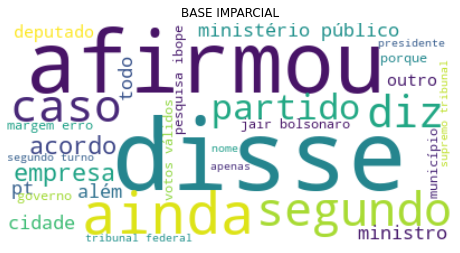

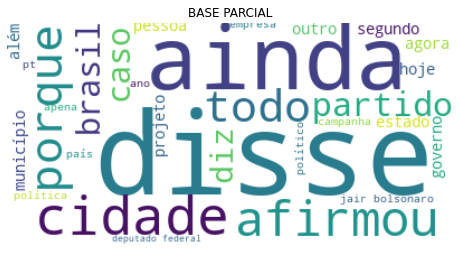

In [26]:
import matplotlib.pyplot as plt

from nltk.probability import FreqDist
from wordcloud import WordCloud

print("PALAVRAS EM DESTAQUE DA BASE")

impartial_base = base[base['predict_senti'] == 'impartial']

impartial_unique_string = impartial_base['article_tokens'].apply(lambda text : (" ").join(text) )
impartial_frequency = FreqDist( impartial_unique_string )
impartial_word_dict = impartial_frequency.keys()

impartial_unique_string = (" ").join(impartial_word_dict)

wordcloud_impartial = WordCloud(
    stopwords=['não'],
    margin=0,
    max_words=30,
    background_color="white"
).generate( impartial_unique_string )

plt.figure(figsize=(8,6))
plt.title("BASE IMPARCIAL")
plt.imshow(wordcloud_impartial, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)



partial_base = base[base['predict_senti'] == 'partial']

partial_unique_string = partial_base['article_tokens'].apply(lambda text : (" ").join(text) )
partial_frequency = FreqDist( partial_unique_string )
partial_word_dict = partial_frequency.keys()

partial_unique_string = (" ").join(partial_word_dict)

wordcloud_partial = WordCloud(
    stopwords=['não'],
    margin=0,
    max_words=30,
    background_color="white"
).generate( partial_unique_string )

plt.figure(figsize=(8,6))
plt.title("BASE PARCIAL")
plt.imshow(wordcloud_partial, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
